In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from IPython import display
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")
plt.ion()

In [2]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

In [3]:
class NET(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(NET, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
STATE_NUMBER = 4
ACTION_NUMBER = 2
LEARNING_RATE = 1e-2
SAMPLE_SIZE = 100

In [5]:
def updateNetwork():
    global sample_memory_bad

    train = torch.tensor([])
    for sample in sample_memory_bad:
        data_state = sample[0]
        
#         noise = torch.tensor(np.random.normal(0, 0.01, data_state[0].size()), dtype=torch.float)
#         data_state[0] = data_state[0] + noise

#         for i in range(4):
#             data_state[0][i] = data_state[0][i]*(1+random.random()/20-0.025)

        train = torch.cat((train, data_state),0)
    with torch.no_grad():
        y_hat = policy(train)

    train1 = torch.tensor([])
    target1 = torch.tensor([])
    for i in range(len(y_hat)):
        if y_hat[i].max(0)[1].view(1, 1).item() == sample_memory_bad[i][1]:
            x = train[i].reshape(1,4)
            train1 = torch.cat((train1, x),0)
            target1 = torch.cat((target1, sample_memory_bad[i][2]),0)

    if len(train1) == 0:
        return
    
    y_hat = policy(train1)
    
    l = policy_loss(y_hat, target1)
    policy_optimizer.zero_grad()
    l.backward()
    policy_optimizer.step()

In [6]:
def updateCritic():
    global one_game 
    one_game.reverse()
    train = torch.tensor([])
    target = torch.tensor([])
    for i,step in enumerate(one_game):
        critic_memory.append([step, torch.tensor([[i*i]])])

    for sample in critic_memory:
        data_state = sample[0]
#         noise = torch.tensor(np.random.normal(0, 0.01, data_state[0].size()), dtype=torch.float)
#         data_state[0] = data_state[0] + noise
        
#         for i in range(4):
#             data_state[0][i] = data_state[0][i]*(1+random.random()/20-0.025)
        
        train = torch.cat((train, data_state),0)
        target = torch.cat((target, sample[1]),0)
    
    y_hat = critic(train)
    l = critic_loss(y_hat, target)
    critic_optimizer.zero_grad()
    l.backward()
    critic_optimizer.step()

In [7]:
sample_memory_bad = deque([], maxlen=SAMPLE_SIZE)
one_game = deque([], maxlen=10)

critic_memory = deque([], maxlen=SAMPLE_SIZE)

episode_durations = []
policy = NET(4, 2)
policy_loss = nn.SmoothL1Loss()
policy_optimizer = optim.AdamW(policy.parameters(), lr=LEARNING_RATE, amsgrad=True)

critic = NET(4, 1)
critic_loss = nn.SmoothL1Loss()
critic_optimizer = optim.AdamW(critic.parameters(), lr=LEARNING_RATE, amsgrad=True)

Complete


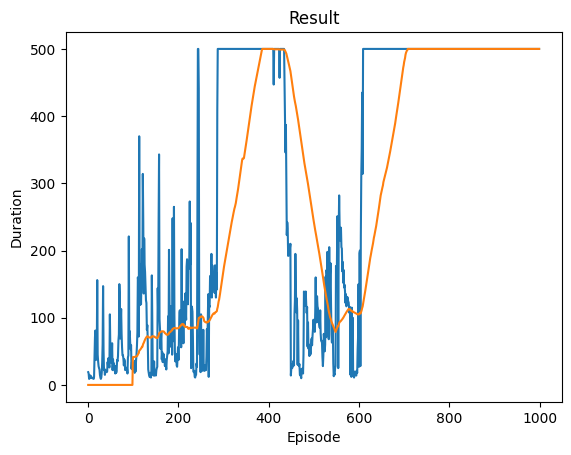

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
printInfo =  []
# games_data = []
for i_episode in range(1000):
    state, info = env.reset()
#     last_reward = 0
    start_time = time.time()
    data_state = torch.tensor(state)

    for t in count():
        if t % 20 == 0:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                y_hat = policy(data_state)
            action = y_hat.max(0)[1].view(1, 1).item()
        
        new_state, _, terminated, truncated, _  = env.step(action)
        data_new_state = torch.tensor(new_state)
        
        with torch.no_grad():
            score = critic(data_state)
            reward =  critic(data_new_state) - score
#         reward_rate = reward - last_reward
        
        
#         label = "Good"
        
        data_state = data_state.reshape(1,4)
        if reward < 0:
#             label = "Bad"
#             , data_new_state, score, reward, reward_rate, y_hat, label
            y = torch.tensor([[1, 1]])
            y[0][action] = 0
            sample_memory_bad.append([data_state, action, y])
            updateNetwork()
        
#         last_reward = reward
        
        one_game.append(data_state)
            
        data_state = data_new_state
        if terminated or truncated:
            end_time = time.time()
            episode_durations.append(t + 1)
            printInfo.append([t + 1 , start_time, end_time])
            plot_durations()
#             games_data.append(one_game)
            if len(one_game) > 0 and terminated:
                updateCritic()
            one_game = []
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [12]:
# printInfo
one_game
# len(printInfo)
# critic_memory[2][0].shape()

deque([tensor([[-0.1517, -1.7966,  0.1925,  2.7574]]),
       tensor([-0.1208, -1.5762,  0.1442,  2.3747]),
       tensor([-0.0932, -1.3801,  0.1031,  2.0520]),
       tensor([-0.0695, -1.1843,  0.0684,  1.7389]),
       tensor([-0.0497, -0.9887,  0.0397,  1.4341]),
       tensor([-0.0338, -0.7934,  0.0170,  1.1361]),
       tensor([-2.1861e-02, -5.9827e-01,  8.3932e-05,  8.4339e-01]),
       tensor([-0.0138, -0.4033, -0.0110,  0.5542]),
       tensor([[-0.0096, -0.2092, -0.0165,  0.2679]]),
       tensor([-0.0094, -0.0135, -0.0159, -0.0209])],
      maxlen=10)

In [129]:
# len(sample_memory_bad)
# sample_memory_bad
len(games_data)

500

In [130]:
# [data_state, action, data_new_state, score, reward, reward_rate, y_hat, label]
for step in games_data[400]:
    data_state = torch.tensor(step[0])
    data_new_state = torch.tensor(step[2])
    
    score = critic(data_state)
    reward = critic(data_new_state) - score
    
    print("state",step[0])
    print("new state",step[2])
    print("action", step[1])
    print("score", step[3].item())
    print("score adjust", score.item())
    print("reward", step[4].item())
    print("label", step[7])
    print(" ")

state tensor([-0.0016, -0.0022, -0.0084, -0.0297])
new state tensor([-0.0017,  0.1930, -0.0090, -0.3251])
action 1
score 132.87118530273438
score adjust 91.04170989990234
reward -1.7451171875
label Good
 
state tensor([-0.0017,  0.1930, -0.0090, -0.3251])
new state tensor([ 0.0022, -0.0020, -0.0155, -0.0352])
action 0
score 131.12606811523438
score adjust 85.00060272216797
reward 2.3970947265625
label Good
 
state tensor([ 0.0022, -0.0020, -0.0155, -0.0352])
new state tensor([ 0.0021,  0.1934, -0.0162, -0.3328])
action 1
score 133.52316284179688
score adjust 91.37346649169922
reward -1.8163909912109375
label Good
 
state tensor([ 0.0021,  0.1934, -0.0162, -0.3328])
new state tensor([ 0.0060, -0.0015, -0.0229, -0.0453])
action 0
score 131.70677185058594
score adjust 84.70207214355469
reward 2.3690032958984375
label Good
 
state tensor([ 0.0060, -0.0015, -0.0229, -0.0453])
new state tensor([ 0.0060,  0.1939, -0.0238, -0.3451])
action 1
score 134.07577514648438
score adjust 91.55677032470

/var/folders/_8/f36rgmf92l39_8tk03fp8fr40000gn/T/ipykernel_9324/2496393161.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_state = torch.tensor(step[0])
/var/folders/_8/f36rgmf92l39_8tk03fp8fr40000gn/T/ipykernel_9324/2496393161.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_new_state = torch.tensor(step[2])


In [117]:
critic_memory

deque([[tensor([-0.0295, -0.0400, -0.0080, -0.0037]), tensor([81])],
       [tensor([-0.1128, -1.6053,  0.1966,  2.5297]), tensor([0])],
       [tensor([-0.0846, -1.4091,  0.1527,  2.1940]), tensor([1])],
       [tensor([-0.0604, -1.2129,  0.1153,  1.8679]), tensor([4])],
       [tensor([-0.0400, -1.0169,  0.0843,  1.5502]), tensor([9])],
       [tensor([-0.0236, -0.8211,  0.0595,  1.2394]), tensor([16])],
       [tensor([-0.0111, -0.6254,  0.0408,  0.9342]), tensor([25])],
       [tensor([-0.0025, -0.4299,  0.0282,  0.6328]), tensor([36])],
       [tensor([ 0.0022, -0.2345,  0.0215,  0.3334]), tensor([49])],
       [tensor([ 0.0030, -0.0391,  0.0208,  0.0342]), tensor([64])],
       [tensor([-0.1602, -1.7150,  0.1693,  2.7099]), tensor([0])],
       [tensor([-0.1298, -1.5190,  0.1216,  2.3825]), tensor([1])],
       [tensor([-0.1034, -1.3232,  0.0803,  2.0661]), tensor([4])],
       [tensor([-0.0808, -1.1275,  0.0451,  1.7597]), tensor([9])],
       [tensor([-0.0622, -0.9322,  0.0158,

In [27]:
one_game

[[array([ 0.00713333, -0.03287031,  0.02383192,  0.01785454], dtype=float32),
  0,
  array([ 0.00647592, -0.22832578,  0.02418901,  0.3179604 ], dtype=float32),
  tensor(0.0007),
  tensor(0.0007),
  array([0.1271626 , 0.11438481], dtype=float32),
  tensor([30.5218], grad_fn=<AddBackward0>)],
 [array([ 0.00647592, -0.22832578,  0.02418901,  0.3179604 ], dtype=float32),
  1,
  array([ 0.00190941, -0.03355656,  0.03054822,  0.03300292], dtype=float32),
  tensor(0.0142),
  tensor(0.0135),
  array([0.11397391, 0.12316199], dtype=float32),
  tensor([31.1374], grad_fn=<AddBackward0>)],
 [array([ 0.00190941, -0.03355656,  0.03054822,  0.03300292], dtype=float32),
  0,
  array([ 0.00123828, -0.22910297,  0.03120828,  0.33516544], dtype=float32),
  tensor(0.0014),
  tensor(-0.0128),
  array([0.12624799, 0.11471323], dtype=float32),
  tensor([29.9203], grad_fn=<AddBackward0>)],
 [array([ 0.00123828, -0.22910297,  0.03120828,  0.33516544], dtype=float32),
  1,
  array([-0.00334378, -0.03443874,  0

In [66]:
a  = torch.tensor([1,2,3,4])
a = a.reshape(1,4)
b = torch.tensor([])
b = torch.cat((b,a,a),0)

In [9]:
import csv
 
printInfo

with open('result.csv', 'w') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(printInfo)

In [103]:
currennt_time = time.time()
train = torch.tensor([])
target = torch.tensor([])

for sample in sample_memory_bad:
    data_state = sample[0]
    with torch.no_grad():
        y_hat = policy(data_state)
    action = y_hat.max(0)[1].view(1, 1).item()

    if action == sample[1]:
        y = torch.tensor([1, 1])
        y[action] = 0


#             noise = torch.tensor(np.random.normal(0, 0.01, data_state.size()), dtype=torch.float)
#             data_state = data_state + noise
#             data_state = data_state.reshape(1,4)

#         for i in range(4):
#             data_state[i] = data_state[i]*(1+random.random()/20-0.025)

        data_state = data_state.reshape(1,4)
        y = y.reshape(1,2)

        train = torch.cat((train, data_state),0)
        target = torch.cat((target, y),0)
print(time.time() - currennt_time)
print(train)

0.01442408561706543
tensor([[-9.9954e-02, -4.6844e-01, -1.7563e-01, -4.1997e-01],
        [-1.3424e-01, -7.3535e-01, -2.3271e-01, -2.0099e-01],
        [-1.6277e-01, -8.3598e-01, -2.4485e-01, -3.2061e-01],
        [-2.7538e-02,  1.8118e-01, -4.7412e-02, -3.2092e-01],
        [-3.6123e-02, -2.5680e-03, -5.5898e-02, -8.0422e-02],
        [-3.6753e-02, -1.3653e-03, -6.2851e-02, -1.0239e-01],
        [-2.6071e-02,  3.8669e-03, -1.0677e-01, -2.2793e-01],
        [-2.6365e-02,  6.0922e-03, -8.3880e-02, -2.5116e-01],
        [-3.0138e-02, -1.6900e-01, -1.2857e-01, -1.5208e-01],
        [-3.7203e-02, -1.9339e-01, -1.3368e-01, -2.6474e-01],
        [-6.1930e-02, -1.8236e-01, -1.4915e-01, -2.8448e-01],
        [-4.4107e-02, -3.9142e-01, -1.2136e-01, -4.6609e-02],
        [-7.1930e-02, -3.1979e-01, -1.4782e-01, -1.4427e-01],
        [-1.0351e-01, -2.6908e-01, -1.9040e-01, -4.7119e-01],
        [-1.2104e-01, -4.5219e-01, -1.7373e-01, -1.4537e-01],
        [-1.5864e-02,  3.3375e-02,  9.9375e-03, -9

In [131]:
currennt_time = time.time()
train = torch.tensor([])
target = torch.tensor([])

for sample in sample_memory_bad:
    data_state = sample[0]
    with torch.no_grad():
        y_hat = policy(data_state)
    action = y_hat.max(0)[1].view(1, 1).item()

    if action == sample[1]:
        y = torch.tensor([1, 1])
        y[action] = 0


#         noise = torch.tensor(np.random.normal(0, 0.01, data_state.size()), dtype=torch.float)
#         data_state = data_state + noise
#         data_state = data_state.reshape(1,4)

        for i in range(4):
            data_state[i] = data_state[i]*(1+random.random()/20-0.025)

        data_state = data_state.reshape(1,4)
        y = y.reshape(1,2)

        train = torch.cat((train, data_state),0)
        target = torch.cat((target, y),0)
print(time.time() - currennt_time)
len(train)

0.02105712890625


58

In [129]:
# sample_memory_bad

In [143]:
currennt_time = time.time()
train = torch.tensor([])
for sample in sample_memory_bad:
    data_state = sample[0]
    for i in range(4):
        data_state[i] = data_state[i]*(1+random.random()/20-0.025)
    data_state = data_state.reshape(1,4)
    train = torch.cat((train, data_state),0)
with torch.no_grad():
    y_hat = policy(train)

train1 = torch.tensor([])
target1 = torch.tensor([])
y_hat1 = torch.tensor([])
for i in range(len(y_hat)):
    if y_hat[i].max(0)[1].view(1, 1).item() == sample_memory_bad[i][1]:
        x = train[i].reshape(1,4)
        train1 = torch.cat((train1, x),0)
        target1 = torch.cat((target1, sample_memory_bad[i][2]),0)
        
print(time.time() - currennt_time)
print(len(train1))
print(len(target1))
print(len(y_hat1))
# print(train1)
# print(target1)
# print(y_hat1)

0.012343883514404297
58
58
0


In [109]:
currennt_time = time.time()
with torch.no_grad():
    for sample in train:
        y_hat = policy(sample)
print(time.time() - currennt_time)
print(y_hat)

0.008121967315673828
tensor([0.5077, 0.5007])


In [104]:
currennt_time = time.time()
with torch.no_grad():
    y_hat = policy(train)
print(time.time() - currennt_time)
print(len(y_hat))

0.0011739730834960938
58


In [124]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [126]:
Transition = namedtuple('Transition',
                        ('a', 'b', 'c'))

test = deque([], maxlen=10)
test.append(Transition(1,2,3))

In [127]:
test.a

AttributeError: 'collections.deque' object has no attribute 'a'